# Topology tutorial

In the movie "Kill Bill", all the brutal action happens after the main character wakes up from a coma and manages to "wiggle your big toe". In a similar way, all the functionality of `seaduck` depends on the `Topology` class.

As the name "topology" suggests, this object describes how the grids are connected in the horizontal dimensions. This is a simple compact model with high performance. It is also designed with expandability in mind.

For any grid configuration not yet supported by this package, only one function must be added to the code, and, with no (or at least, very little) extra effort, this module (and therefore the entire package) should work for the new configuration.

The magic function is simply: Given a center grid point and its index, if you one want to step one grid point to the up/down/left/right what would the new index be?

And that's it.

In [1]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np

import seaduck as sd

For this example, we are going to use ECCO dataset (see [this ECCO notebook](./global_ECCO)). Crucially, this dataset has 13 faces.

In [2]:
ds = sd.utils.get_dataset("ecco")[["UVELMASS", "VVELMASS"]].isel(time=0, Z=0)
ds

<xarray.Dataset>
Dimensions:   (face: 13, Y: 90, Xp1: 90, Yp1: 90, X: 90)
Coordinates: (12/32)
    CS        (face, Y, X) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    Depth     (face, Y, X) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    HFacC     (face, Y, X) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    HFacS     (face, Yp1, X) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    HFacW     (face, Y, Xp1) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    PHrefC    float32 dask.array<chunksize=(), meta=np.ndarray>
    ...        ...
    rA        (face, Y, X) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    rAs       (face, Yp1, X) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    rAw       (face, Y, Xp1) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    rAz       (face, Yp1, Xp1) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    time      datetime64[ns] 1992-01-16T12:00:00
    timestep  int64 dask.array<chunksize=(), meta=np.ndarray>
Data variables:
    UVELMASS  (face, Y, Xp1) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    VVELMASS  (face, Yp1, X) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes: (12/16)
    OceanSpy_description:       ECCO v4r4 3D dataset, ocean simulations on LL...
    OceanSpy_face_connections:  {'face': {0: {'X': ((12, 'Y', False), (3, 'X'...
    OceanSpy_grid_coords:       {'Y': {'Y': None, 'Yp1': -0.5}, 'X': {'X': No...
    OceanSpy_name:              ECCO_v4r4
    OceanSpy_parameters:        {'rSphere': 6371.0, 'eq_state': 'jmd95', 'rho...
    date_created:               Mon Dec 30 11:13:26 2019
    ...                         ...
    geospatial_vertical_max:    -5.0
    geospatial_vertical_min:    -5906.25
    nx:                         90
    ny:                         90
    nz:                         50
    title:                      ECCOv4 MITgcm grid information

We can either directly create the `Topology` object

In [3]:
tp = sd.Topology(ds)

Or we can access it as a attribute of `OceData` object

In [4]:
tub = sd.OceData(ds)
tp = tub.tp

Let's start with the most fundamental method of the object. Simply find the neighboring grid points:

In [5]:
help(tp.ind_tend)

Help on method ind_tend in module seaduck.topology:

ind_tend(ind, tend, cuvwg='C', **kwarg) method of seaduck.topology.Topology instance
    Move an index in a direction.
    
    ind is a tuple that is face,iy,ix,
    tendency again is up, down, left, right represented by 0,1,2,3
    return the next cell.
    
    Parameters
    ----------
    ind: tuple
        The index to find the neighbor of
    tend: int
        Which direction to move from the original index.
    cuvwg: str, default "C"
        Whether we are moving from C grid, U grid, V grid, or G grid.
    kwarg:dict, optional
        Keyword argument that currently only apply for the llc case.



Here, 0-3 represent up/down/left/right respectively.

In [6]:
face = 10
iy = 89
ix = 89
ind = (face, iy, ix)

In [7]:
tp.ind_tend(ind, 0), tp.ind_tend(ind, 1), tp.ind_tend(ind, 2), tp.ind_tend(ind, 3)

((2, 0, 0), (10, 88, 89), (10, 89, 88), (11, 89, 0))

You could also use the function on staggered grids, and sometimes you get a different result.

In [8]:
tp.ind_tend(ind, 0, cuvwg="U"), tp.ind_tend(ind, 0)

((2, 1, 0), (2, 0, 0))

This is all very nice, because it's definitely a pain to navigate grids. But how can I actually apply this?

## Calculate surface vorticity

This example is going to use `Topology` to compute vorticity on ECCO. As this notebook is written, packages like `xgcm` do not support vorticity calculation on grids with complex topology. I don't think I need to tell you it's a pain to write it out yourself.

Let's begin by defining the points of interest. In this example, it's every single corner point in the dataset:

In [9]:
face, iy, ix = np.indices((13, 90, 90))
face = face.ravel()
iy = iy.ravel()
ix = ix.ravel()

ind = (face, iy, ix)

We can also directly read the grid coords here.

In [10]:
lon = tub.XG[ind]
lat = tub.YG[ind]

dx = tub.dX[ind]
dy = tub.dY[ind]
# Ideally, dxV and dyU should be used for accuracy.

If you are not familiar with LLC grids, here is what it looks like. Different colors represent different "faces", which aren't necessarily parallel to each other.

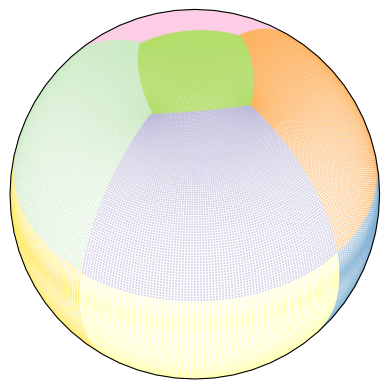

In [11]:
ax = plt.axes(
    projection=ccrs.Orthographic(
        central_longitude=0.0,
        central_latitude=45.0,
    )
)
ax.scatter(lon, lat, s=0.1, c=face, transform=ccrs.PlateCarree(), cmap="Set3")
plt.show()

Every corner point is connected to 4 staggered velocity points. For MITgcm indexing, the upper and right one has the same index as the corner, so we could just read in that.

In [12]:
u = np.array(ds.UVELMASS)
v = np.array(ds.VVELMASS)

In [13]:
U_up = u[ind]
V_right = v[ind]

We can use the `ind_tend_vec` function to figure out the other two indexes for the velocity points.

The next line is going to have a warning, because some of the points we defined on continental Antarctica don't have neighboring points. Since, they are on land, it does not matter as far as we are concerned.

In [14]:
ind_left = tp.ind_tend_vec(ind, 2 * np.ones_like(face), cuvwg="V")
ind_down = tp.ind_tend_vec(ind, 1 * np.ones_like(face), cuvwg="U")

Let's just read the velocities at the other points.

In [15]:
U_down = u[tuple(ind_down)]
V_left = v[tuple(ind_left)]

It's actually not as simple as that. Grids are not always parallel to each other. For example, sometimes $U$ becomes $V$, and $V$ becomes $-U$.

Well, the `Topology` object takes care of that as well with little additional effort.

In [16]:
V_down = v[tuple(ind_down)]
U_left = u[tuple(ind_left)]

In [17]:
fc1 = ind[0]
fc2 = ind_left[0].astype(int)
fc3 = ind_down[0].astype(int)

where = np.where(fc1 != fc3)[0]
for i in where:
    faces = np.array([fc1[i], fc3[i]])
    UfromUvel, UfromVvel, _, _ = tp.get_uv_mask_from_face(faces)
    U_down[i] = UfromVvel[1] * V_down[i] + UfromUvel[1] * U_down[i]

where = np.where(fc1 != fc2)[0]
for i in where:
    faces = np.array([fc1[i], fc2[i]])
    _, _, VfromUvel, VfromVvel = tp.get_uv_mask_from_face(faces)
    V_left[i] = VfromVvel[1] * V_left[i] + VfromUvel[1] * U_left[i]

Ha, we got everything we need. Let's calculate the velocity and plot it.

In [18]:
vor = (V_right - V_left) / dx + (U_down - U_up) / dy

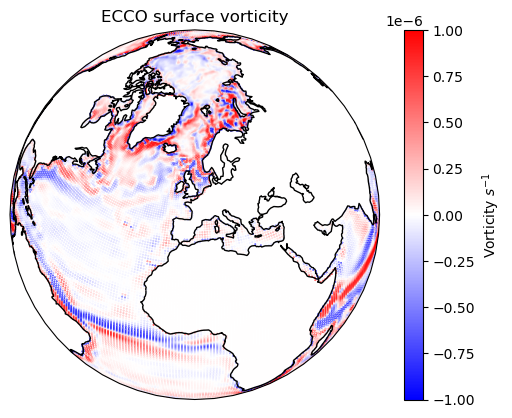

In [19]:
ax = plt.axes(
    projection=ccrs.Orthographic(
        central_longitude=0.0,
        central_latitude=45.0,
    )
)
c = ax.scatter(
    lon,
    lat,
    s=0.1,
    c=vor,
    transform=ccrs.PlateCarree(),
    cmap="bwr",
    vmax=1e-6,
    vmin=-1e-6,
)
ax.coastlines()
ax.set_title("ECCO surface vorticity")
plt.colorbar(c, label=r"Vorticity $s^{-1}$")
plt.show()